Checking the impact of image normalization on the latent and self-&cross-attention maps.

Stable Diffusion requires normalization to [-1,1]
as stated in [here](https://keras.io/examples/generative/finetune_stable_diffusion/#:~:text=tf.keras.layers.Rescaling(scale%3D1.0%20/%20127.5%2C%20offset%3D%2D1)%2C) and  [here](https://keras.io/examples/generative/fine_tune_via_textual_inversion/#:~:text=%23%20The%20StableDiffusion%20image%20encoder%20requires%20images%20to%20be%20normalized%20to%20the%0A%20%20%20%20%23%20%5B%2D1%2C%201%5D%20pixel%20value%20range%0A%20%20%20%20images%20%3D%20images%20/%20127.5%20%2D%201).



# Import

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from diffusion_models.stable_diffusion import StableDiffusion
from diffseg.segmentor import DiffSeg

# !nvidia-smi # Uncomment if you have an NVIDIA GPU


Using TensorFlow backend


In [2]:
print(f"GPUs available: ", tf.config.experimental.list_physical_devices('GPU'))
device = tf.test.gpu_device_name()
print(tf.test.gpu_device_name())

GPUs available:  []



# Models

In [5]:
# Inialize Stable Diffusion Model on GPU:0
with tf.device(device):
    model = StableDiffusion(img_width=512, img_height=512)
    image_encoder = model.image_encoder # vae encoder

    

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE



# Latent representation of the image

In [6]:
from utils.utils import get_image, crop_and_scale_image, normalize_0to1, normalize_m1to1

In [30]:
image_path = "./images/polar_bear.jpg"  # Specify the path to your image


with tf.device(device):
    image = get_image(image_path)
    image = crop_and_scale_image(image)

    image = normalize_m1to1(image)
    #image = normalize_0to1(image)

    images = tf.expand_dims(image, axis=0) # encoder expects a tensor of shape (batch_size, height, width, channels) so we add a batch dimension
    latent = image_encoder(images, training=False)
    


#### Visualise the VAE latents

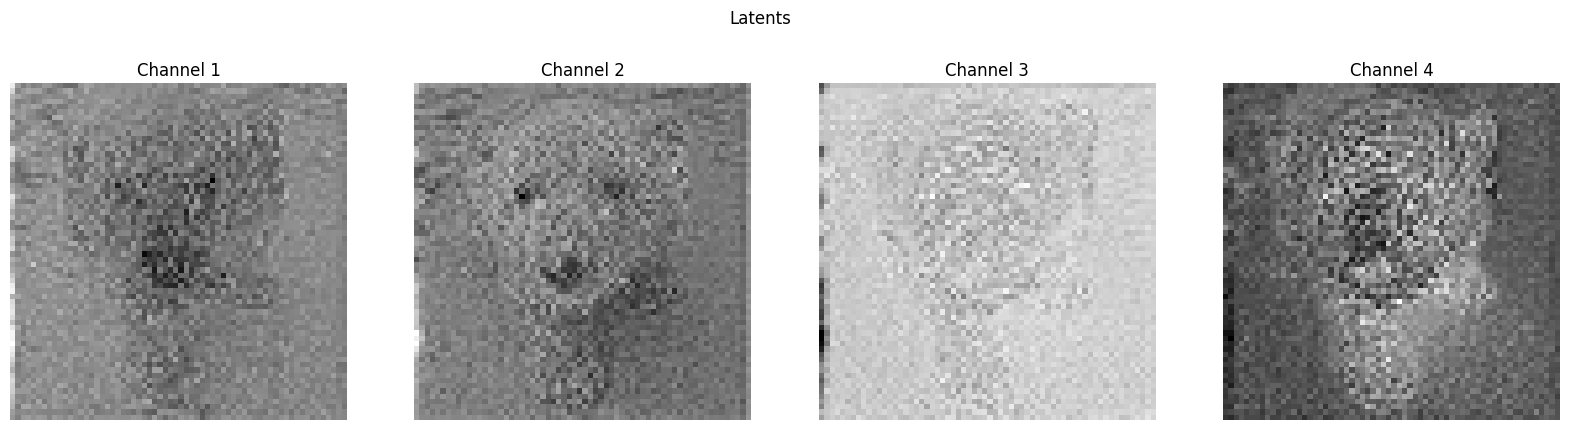

In [31]:
# Plotting the latents
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Loop over each channel
for i in range(4):
    channel = latent[0, :, :, i]
    axs[i].imshow(channel, cmap="gray")
    axs[i].set_title(f"Channel {i+1}")
    axs[i].axis("off")  # Hide axis

fig.suptitle("Latents")
plt.show()

# Self- & cross-attention maps

In [32]:
prompt = ""
context = model.encode_text(prompt)

timestep = 999

with tf.device(device):
    self_attn_64,  self_attn_32,  self_attn_16,  self_attn_8, cross_attn_64, cross_attn_32, cross_attn_16, cross_attn_8, = model.generate_image(encoded_text=context, latent=latent, timestep=timestep)


In [33]:
# Dictionary of structure { timestep : { resolution : self-attention map } }
from typing import Dict
import numpy as np

self_attn_dict:  Dict[int, Dict[int, np.ndarray]] = { }
cross_attn_dict: Dict[int, Dict[int, np.ndarray]] = { }

# Average attention heads and store attention maps for current time step
self_attn_dict[timestep] = {
    8:  self_attn_8.mean(axis=(0, 1)),
    16: self_attn_16.mean(axis=(0, 1)),
    32: self_attn_32.mean(axis=(0, 1)),
    64: self_attn_64.mean(axis=(0, 1)),
}

cross_attn_dict[timestep] = {
    8:  cross_attn_8.mean(axis=(0, 1)),
    16: cross_attn_16.mean(axis=(0, 1)),
    32: cross_attn_32.mean(axis=(0, 1)),
    64: cross_attn_64.mean(axis=(0, 1)),
}

In [34]:
t = 999         #0,111,222,333,444,555,666,777,888,999
res = 64        # 8, 16, 32, 64
token = 0       # 0-76
cross_attn = cross_attn_dict[t][res].reshape(res, res, 77)

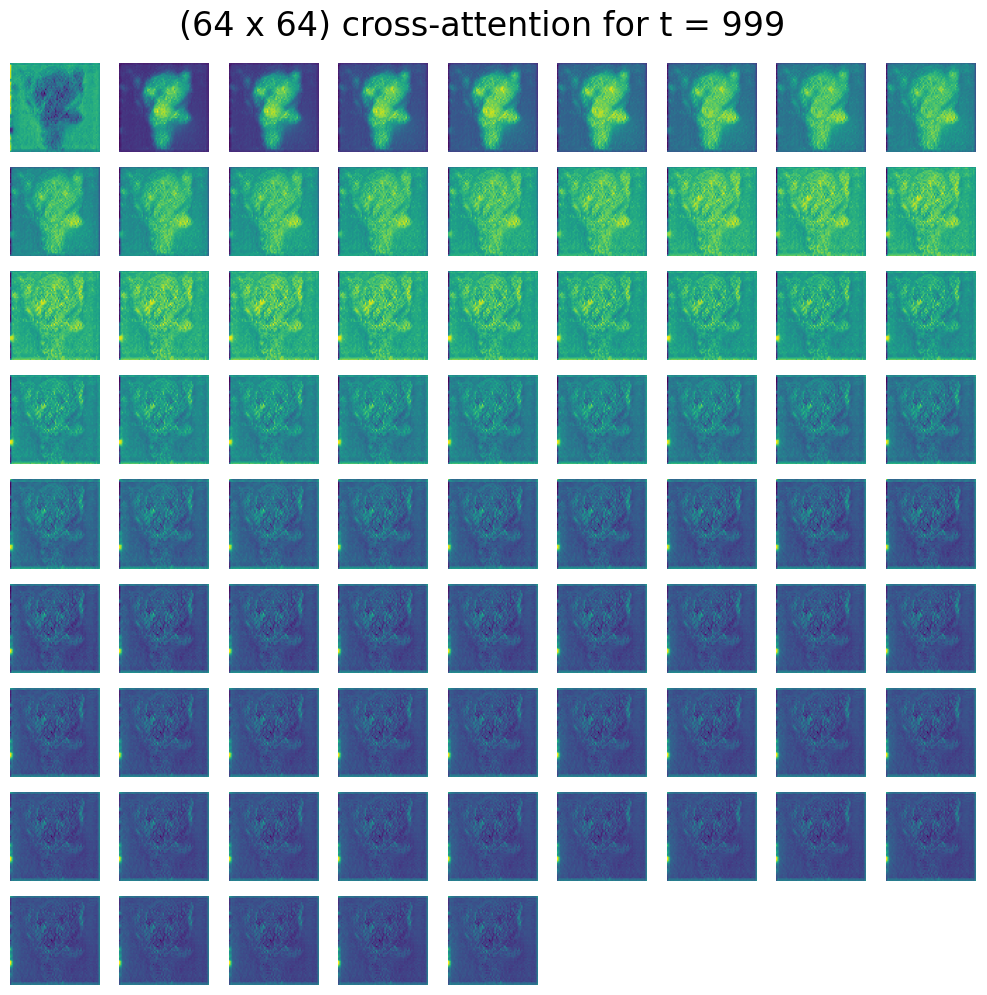

In [35]:
fig, axs = plt.subplots(9, 9, figsize=(10, 10))
axs = axs.flatten()

for idx, ax in enumerate(axs):
    if idx < 77:
        ax.imshow(cross_attn[:, :, idx])
    ax.axis('off')

fig.suptitle(f"({res} x {res}) cross-attention for t = {t} {'(unconditional)' if context is None else ''} ", fontsize=24, y=0.99)
fig.tight_layout()